# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import pandas as pd
from scipy import signal
import keras
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)

from optimizers.sgd import SGD
from optimizers.adam import Adam
from network import Network
# from layers.conv2d import Conv2D
# from layers.dense import FCLayer
# from layers.activation import ActivationLayer, SoftmaxLayer, tanh, tanh_prime, softmax, softmax_prime, relu, relu_prime, sigmoid, sigmoid_prime
# from layers.flatten import FlattenLayer
from losses import mse, mse_prime
from layers import Conv2D, FCLayer, ActivationLayer, SoftmaxLayer, FlattenLayer, DropoutLayer, PoolingLayer, GlobalAveragePoolingLayer, RNN
from activations import tanh, tanh_prime, relu, relu_prime, sigmoid, sigmoid_prime, softmax, softmax_prime

2024-05-01 03:02:35.446484: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 03:02:35.465833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 03:02:35.465853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 03:02:35.466433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 03:02:35.469902: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def visualize_test_samples(x_test,y_test,samples,network):
  for test, true in zip(x_test[:samples], y_test[:samples]):
    pred = network.predict([test])[0][0]
    idx = np.argmax(pred)
    idx_true = np.argmax(true)
    plt.title('pred: %s, prob: %.2f, true: %d' % (idx, pred[idx], idx_true))
    plt.imshow(test, cmap='binary')
    plt.show()

In [3]:
def adjust_data(image,is_conv=False):
  image = np.cast['float32'](image)
  if is_conv:
    image = np.expand_dims(image,axis=-1)
  image/=255
  return image

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train_new = adjust_data(x_train,True)
y_train_new = keras.utils.to_categorical(y_train)
x_test_new = adjust_data(x_test,True)
y_test_new = keras.utils.to_categorical(y_test)

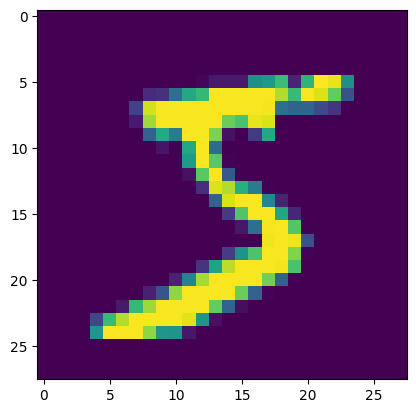

In [6]:
plt.imshow(x_train_new[0])

# SGD

In [9]:
# Network
net_conv = Network()
net_conv.set_optimizer(SGD(learning_rate=0.1))
net_conv.add(Conv2D(3,5))
net_conv.add(FlattenLayer())
net_conv.add(FCLayer(100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv.add(FCLayer(50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv.add(FCLayer(10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
# net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv.add(SoftmaxLayer())

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net_conv.use(mse, mse_prime)
net_conv.fit(x_train_new[0:1000], y_train_new[0:1000], epochs=5)

epoch 1: loss=0.05611376955389422
epoch 2: loss=0.028267718226634497
epoch 3: loss=0.02033760856368539
epoch 4: loss=0.018290192490209408
epoch 5: loss=0.017911864999240894


# Adam

In [14]:
net_conv_adam = Network()
net_conv_adam.set_optimizer(Adam(learning_rate=0.001))
net_conv_adam.add(Conv2D(3,5))
net_conv_adam.add(FlattenLayer())
net_conv_adam.add(FCLayer(100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net_conv_adam.add(ActivationLayer(relu, relu_prime))
net_conv_adam.add(FCLayer(50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net_conv_adam.add(ActivationLayer(relu, relu_prime))
net_conv_adam.add(FCLayer(10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net_conv.add(ActivationLayer(softmax, softmax_prime))
# net_conv_adam.add(SoftmaxLayer())

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net_conv_adam.use(mse, mse_prime)
net_conv_adam.fit(x_train_new[0:1000], y_train_new[0:1000], epochs=5)

epoch 1: loss=0.09688174628003442
epoch 2: loss=0.08496732703875612
epoch 3: loss=0.08601672304494114
epoch 4: loss=0.08356162061799587
epoch 5: loss=0.08322499598516125


# RNN

In [2]:
np.random.seed(42)

def create_dataset(num_sequences, sequence_length):
    return np.array([np.arange(start, start + sequence_length) for start in range(num_sequences)])

# Helper function to create inputs and targets from the sequences
def create_inputs_targets(data):
    X = data[:, :-1]  # all but the last item in each sequence as input
    Y = data[:, -1]  # all but the first item in each sequence as target (for sequence prediction)
    return X, Y

# Helper function to create batches
def create_batches(X, Y, batch_size):
    num_batches = len(X) // batch_size
    X_batches = np.array(np.array_split(X, num_batches))
    Y_batches = np.array(np.array_split(Y, num_batches))
    return X_batches, Y_batches

# Generate dataset
num_sequences = 1000  # The number of sequences you want
sequence_length = 4  # The length of each sequence
batch_size = 1  # The size of each batch

# Create dataset
dataset = create_dataset(num_sequences, sequence_length)

# Split dataset into training and testing sets (80-20 split)
train_size = int(num_sequences * 0.8)
train_set, test_set = dataset[:train_size], dataset[train_size:]

# Create inputs (X) and targets (Y) for training and testing
x_train, y_train = create_inputs_targets(train_set)
x_test, y_test = create_inputs_targets(test_set)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(x_train.shape, y_train.shape)
# Shuffle training data
indices = np.arange(train_size)
np.random.shuffle(indices)

# Apply shuffled indices to create shuffled training data
x_train_shuffled = x_train[indices]
y_train_shuffled = y_train[indices]
# Normalize inputs
# x_train_max = np.max(x_train_shuffled)
# x_train_shuffled = x_train_shuffled / x_train_max
# x_test = x_test / x_train_max  # use the same scale as train set

# print(x_train_shuffled.shape, y_train_shuffled.shape)
# # Create batches from the training and testing data
# x_train_batches, y_train_batches = create_batches(x_train_shuffled, y_train_shuffled, batch_size)
# x_test_batches, y_test_batches = create_batches(x_test, y_test, batch_size)


# Example: Print the first training batch
# print("First training batch (x_train, y_train):")
# print(x_train_batches.shape, y_train_batches.shape)
# x_train_batches[0], y_train_batches[0]

(800, 3, 1) (800,)


In [3]:
net_conv_adam = Network()
net_conv_adam.set_optimizer(Adam(learning_rate=0.001, t=0))
net_conv_adam.add(RNN(hidden_size=20,output_size=30, return_sequences=False, init='glorot_uniform'))
# net_conv_adam.add(RNN(hidden_size=20,output_size=30, return_sequences=False))
net_conv_adam.add(FlattenLayer())
# net_conv_adam.add(FCLayer(output_dim=50))
net_conv_adam.add(FCLayer(output_dim=1))
# net_conv_adam.add(SoftmaxLayer())

# train on 1000 samples
# we didn't implemented mini-batch GD
net_conv_adam.use(mse, mse_prime)
net_conv_adam.fit(x_train=x_train, y_train=y_train, epochs=100)

epoch 1: loss=206461.32951487423
epoch 2: loss=194116.27233525907
epoch 3: loss=183443.20241076447
epoch 4: loss=173518.77349613313
epoch 5: loss=164180.55849426816
epoch 6: loss=155365.54735100552
epoch 7: loss=147041.92118979502
epoch 8: loss=139190.54655498068
epoch 9: loss=131797.7818249144
epoch 10: loss=124852.21576141458
epoch 11: loss=118343.09235438723
epoch 12: loss=112259.5304732854
epoch 13: loss=106590.1331445518
epoch 14: loss=101322.79261126526
epoch 15: loss=96444.59792180479
epoch 16: loss=91941.80110879068
epoch 17: loss=87799.82211701517
epoch 18: loss=84003.2840748279
epoch 19: loss=80536.07552272256
epoch 20: loss=77381.43794402046
epoch 21: loss=74522.07697070552
epoch 22: loss=71940.29480288716
epoch 23: loss=69618.14017690395
epoch 24: loss=67537.57097916576
epoch 25: loss=65680.62358066971
epoch 26: loss=64029.58234504852
epoch 27: loss=62567.14265385457
epoch 28: loss=61276.56122860304
epoch 29: loss=60141.788460456926
epoch 30: loss=59147.57876698501
epoch 31

In [4]:
test = np.array([[10,11,12]])
test = np.expand_dims(test, axis=-1)
np.round(net_conv_adam.predict(test))

array([[[417.]]])

In [5]:
net_conv_adam.summary()

,type,input_shape,output_shape,fc_layer_shape,kernels_shape,number_of_params
0,RNN,"(3, 1)","(20,)",None,None,440
1,FlattenLayer,"(20,)","(1, 20)",None,None,0
2,FCLayer,"(1, 20)","(1, 1)","(20, 1)",None,21
3,Total number of params,,,,,461


In [7]:
def learning_rate_decay(epoch, optimizer):
    if epoch != 0 and epoch % 50 == 0:
        optimizer.learning_rate *= 0.99

net_conv_adam = Network()
net_conv_adam.set_optimizer(Adam(learning_rate=0.1, t=0))
net_conv_adam.add(RNN(hidden_size=20,output_size=30, return_sequences=True,bidirectional=True, init='glorot_uniform', activation='relu'))
net_conv_adam.add(RNN(hidden_size=20,output_size=30, return_sequences=False, bidirectional=True, init='glorot_uniform'))
net_conv_adam.add(FlattenLayer())
# net_conv_adam.add(FCLayer(output_dim=50))
net_conv_adam.add(FCLayer(output_dim=1))

# we didn't implement mini-batch GD
net_conv_adam.use(mse, mse_prime)
net_conv_adam.set_learning_rate_scheduler(learning_rate_decay)
net_conv_adam.fit(x_train=x_train, y_train=y_train, epochs=100)

epoch 1: loss=0.05099273701819455
epoch 2: loss=13249.740727372679
epoch 3: loss=14749.407963355394
epoch 4: loss=15250.752942708701
epoch 5: loss=15492.481381005673
epoch 6: loss=15622.466162419676
epoch 7: loss=15695.41284485934
epoch 8: loss=15737.109844625535
epoch 9: loss=15761.141082024957
epoch 10: loss=15775.042803035232
epoch 11: loss=15783.09837473718
epoch 12: loss=15787.76982950266
epoch 13: loss=15790.479695590704
epoch 14: loss=15792.051856900975
epoch 15: loss=15792.963996259414
epoch 16: loss=15793.493200779878
epoch 17: loss=15793.800228715167
epoch 18: loss=15793.978352795524
epoch 19: loss=15794.081690347573
epoch 20: loss=15794.141639857253
epoch 21: loss=15794.176417997249
epoch 22: loss=15794.19659337004
epoch 23: loss=15794.208297317833
epoch 24: loss=15794.215086847486
epoch 25: loss=15794.219025468892
epoch 26: loss=15794.221310260786
epoch 27: loss=15794.222635661932
epoch 28: loss=15794.223404521004
epoch 29: loss=15794.22385053153
epoch 30: loss=15794.224109

In [8]:
test = np.array([[10,11,12]])
test = np.expand_dims(test, axis=-1)
np.round(net_conv_adam.predict(test))

array([[[777.]]])

In [9]:
net_conv_adam.summary()

,type,input_shape,output_shape,fc_layer_shape,kernels_shape,number_of_params
0,RNN,"(3, 1)","(3, 40)",None,None,880
1,RNN,"(3, 40)","(40,)",None,None,2440
2,FlattenLayer,"(40,)","(1, 40)",None,None,0
3,FCLayer,"(1, 40)","(1, 1)","(40, 1)",None,41
4,Total number of params,,,,,3361


In [13]:
net_conv_sgd = Network()
net_conv_sgd.set_optimizer(SGD())
net_conv_sgd.add(RNN(hidden_size=20,output_size=30, return_sequences=False))
net_conv_sgd.add(FlattenLayer())
net_conv_sgd.add(FCLayer(output_dim=1))
# net_conv_adam.add(SoftmaxLayer())

# train on 1000 samples
# we didn't implemented mini-batch GD
net_conv_sgd.use(mse, mse_prime)
net_conv_sgd.fit(x_train=x_train_shuffled, y_train=y_train_shuffled, epochs=100)

/root/ml/Deep-Learning-Fundamentals/layers/rnn.py:226: RuntimeWarning: invalid value encountered in cast
  dX[i, :] = dht_dxt


epoch 1: loss=67342.6897958377
epoch 2: loss=66715.57087041353
epoch 3: loss=66715.57087041353
epoch 4: loss=66715.57087041353
epoch 5: loss=66715.57087041352
epoch 6: loss=66715.57087041352
epoch 7: loss=66715.57087041353
epoch 8: loss=66715.57087041353
epoch 9: loss=66715.57087041353
epoch 10: loss=66715.57087041353
epoch 11: loss=66715.57087041352
epoch 12: loss=66715.57087041353
epoch 13: loss=66715.57087041353
epoch 14: loss=66715.57087041352
epoch 15: loss=66715.57087041353
epoch 16: loss=66715.57087041353
epoch 17: loss=66715.57087041353
epoch 18: loss=66715.57087041353
epoch 19: loss=66715.57087041353
epoch 20: loss=66715.57087041353
epoch 21: loss=66715.57087041353
epoch 22: loss=66715.57087041353
epoch 23: loss=66715.57087041353
epoch 24: loss=66715.57087041353
epoch 25: loss=66715.57087041353
epoch 26: loss=66715.57087041353
epoch 27: loss=66715.57087041353
epoch 28: loss=66715.57087041353
epoch 29: loss=66715.57087041353
epoch 30: loss=66715.57087041353
epoch 31: loss=66715